## Assignment 3 AI5100
Name : SADINENI ABHINAY

Roll NO: CS21BTECH11055

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

#importing these libaraies (for dataset download only) didn't use anywhere else
import torchvision
import torchvision.transforms as transforms

In [2]:
if(torch.cuda.is_available()): torch.cuda.empty_cache()

torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

### DataSet Download 

In [3]:
#Used  PY torch tutorials(official) Normalization values 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))  
])

# Load CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Load CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(len(train_loader.dataset))  # Number of batches in training set

Files already downloaded and verified
Files already downloaded and verified
50000


In [4]:
def evaluate(model , test_loader):
    # Evaluate the model on the test set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            predicted = torch.argmax(outputs.data, dim=1)  
            total += labels.size(0)
            print(labels.size())
            correct += (predicted.squeeze() == labels).sum().item()  
    accuracy = (correct / total) * 100
    print('Accuracy on the test dataset: %.2f %%' % accuracy)
    return accuracy

In [17]:
for data in test_loader:
    print(data[0].size())

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
torch.Size([12

## 1. Object Recognition using CNN and self attention layers
Consider Image , and pass it thorught Convolution layer we will get CxHxW activation map


Inside a Self attention layer:
* Here each we are giving an input of HxW elements with each element of C dimension
* Then do a 1x1 convolution with three different set of W<sub>q</sub> W<sub>k</sub> W<sub>v</sub> to get queries , keys , values
* Let Q , K , V be query , key , value vectors with dimensions C'xHxW
* now calculate self attention vector : softmax(QK^T)V
* now do 1x1 convolution and convert this attention to CxHxW and add to original activation map and return the output

In [5]:
#self attention layer
class SelfAttentionLayer_CNN(nn.Module):

        def __init__(self, C , D_Q , D_V ):
            super(SelfAttentionLayer_CNN, self).__init__()
            self.C = C
            self.D_Q = D_Q
            self.D_V = D_V
            self.conv_Q = nn.Conv2d(C, D_Q , kernel_size=1, stride=1, padding=0)
            self.conv_K = nn.Conv2d(C, D_Q , kernel_size=1 , stride=1 , padding=0)
            self.conv_V = nn.Conv2d(C, D_V , kernel_size=1 ,stride=1 ,padding=0)
            self.conv_S = nn.Conv2d(D_V , C , kernel_size=1 ,stride=1 ,padding=0)

        def forward(self , X):
             size = X.size()
             
             #get query , key , value
             Q = self.conv_Q(X)
             K = self.conv_K(X)
             V = self.conv_V(X)
 
             Q = Q.view(size[0] , self.D_Q, size[2]*size[3])  # batch x D_q x (HW)
             K = K.view(size[0], self.D_Q , size[2]*size[3])  # batch x D_q x (HW)
             V = V.view(size[0] , self.D_V ,size[2]*size[3])  # batch x D_v x (HW)

            # Calculate dot product for attention
             dot_products =  torch.bmm(K.transpose(1,2), Q)/ torch.sqrt(torch.tensor(self.D_Q, dtype=torch.float32))  # batch x [ ( D_q x HW)T (D_q x HW )]

             softmax = torch.nn.functional.softmax(dot_products, dim=2) # batch x HWxHW
            
            #Multiple with value
             self_attention =  torch.bmm(V, softmax)  # batch x[ (D_v x HW)(D_V xHW)]

             self_attention =  self_attention.view(size[0] ,self.D_V , size[2] ,size[3] ) # batch x D_v x H x W
            
             #again do convolution to get attention to input value
             # Add residual connection 
             add_residual = self.conv_S(self_attention) + X #   batch x C x H x W

             return  add_residual




### CNN_SA Network archiecture
 CONV - > MAXPOOL -> 4x [ CONV -> SelfAttention] -> CONV -> GAP

In [6]:
#Object reconginition with CNN and SA

class Object_reconginition_CNN_SA(nn.Module):
    def __init__(self, C_in, C_in_SA, D_Q, D_V, N_C):
        super(Object_reconginition_CNN_SA, self).__init__()

        #First Convolution Layer
        self.conv0 = nn.Conv2d(C_in, C_in_SA, kernel_size=3, stride=1, padding=0)
        self.relu0 = nn.ReLU()

        #Max Pool Layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Four blocks of Convolution followed by Self Attention Layer
        self.module_list = nn.Sequential(*[nn.Sequential(

            nn.Conv2d(C_in_SA, C_in_SA, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),

            SelfAttentionLayer_CNN(C_in_SA, D_Q, D_V)
        ) for i in range(4)])

        #Last Convolution Layer
        self.conv_last = nn.Conv2d(C_in_SA, N_C, kernel_size=3, stride=1, padding=0)
        self.relu_last = nn.ReLU()

        #GAP
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    #Forward Function that feeds the input to the network
    def forward(self, X):
        X = self.conv0(X)
        X = self.relu0(X)
        X = self.maxpool(X)
        for module in self.module_list:
            X = module(X)
        X = self.conv_last(X)
        X = self.relu_last(X)
        X = self.global_avg_pool(X)
        return X


    # Train the model
    def train_model(self, train_loader, learning_rate, epochs, batch_size,  device):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        print("Training CNN-SA Network:")

        Train_loss_data = []

        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):

                #Save inputs in device
                inputs, labels = data[0].to(device), data[1].to(device) 

                #Clear the gradient
                optimizer.zero_grad()
                outputs = self(inputs)  
                loss = criterion(outputs.squeeze(), labels)  

                #Go backward
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()

            print('epoch : %d ------> loss: %.3f' %
                  (epoch + 1, running_loss / len(train_loader)))
            Train_loss_data.append(running_loss / len(train_loader))

        return Train_loss_data


In [7]:
# Training constraints
epochs = 10
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your model
model = Object_reconginition_CNN_SA(C_in=3, C_in_SA=32, D_Q=16, D_V=16, N_C=10).to(device)

#Train the model
Train_loss_data1 = model.train_model(train_loader, lr, epochs, 128 , device=device)

Training CNN-SA Network:
epoch : 1 ------> loss: 2.214
epoch : 2 ------> loss: 1.909
epoch : 3 ------> loss: 1.348
epoch : 4 ------> loss: 1.160
epoch : 5 ------> loss: 1.049
epoch : 6 ------> loss: 0.974
epoch : 7 ------> loss: 0.922
epoch : 8 ------> loss: 0.878
epoch : 9 ------> loss: 0.842
epoch : 10 ------> loss: 0.807


In [8]:
AC1 = evaluate(model,test_loader)

torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size

## 2. Object Recognition with Vision Transformer
This model is based on encoder only transformer 
 

**Multi Headed Attention Layer**

In [9]:
class MHA_layer(nn.Module):
    def __init__(self, input_dim , N_heads , D_Q , D_V ):
        super(MHA_layer, self).__init__()
        self.N_heads = N_heads
        self.input_dim = input_dim
        self.D_Q = D_Q
        self.D_V = D_V
        self.WQ = nn.Linear(input_dim, D_Q * N_heads)
        self.WK = nn.Linear(input_dim, D_Q * N_heads)
        self.WV = nn.Linear(input_dim, D_V * N_heads)
        self.OUT = nn.Linear(D_V * N_heads , input_dim)

    def forward(self ,x):
        size = x.size() # batch x N x input_dim
        query = self.WQ(x).view(size[0], size[1] , self.N_heads,  self.D_Q ).transpose(1, 2) # batch x n_heads x N x D_Q
        key   = self.WK(x).view(size[0] , size[1] , self.N_heads , self.D_Q).transpose(1, 2) # batch x n_heads x N x D_K
        value = self.WV(x).view(size[0] , size[1] , self.N_heads , self.D_V).transpose(1, 2) # batch x n_heads x N x D_K

        # Attention calculation same as normal self attention by small varaition because of multiple heads
        dot_products = torch.matmul(query , key.transpose(-2,-1))/ torch.sqrt(torch.tensor(self.D_Q, dtype=torch.float32))

        softmax = F.softmax(dot_products,dim=-1)

        self_attention = torch.matmul(softmax,value)
           
        self_attention_concatnated = self_attention.transpose(1,2)

        # transpose operation may have introduced non-contigous memory 
        self_attention_concatnated = self_attention_concatnated.contiguous()

        #concatnate the values from the heads
        self_attention_concatnated = self_attention_concatnated.view(size[0],size[1],-1)

        output = self.OUT(self_attention_concatnated)

        return output

**Encoder Block**
A single encoder block consists of the following layers
*  Multi-Head Attention Layer
*  Residual Connection
*  Normalization Layer
*  MLP
*  Residual Connection
*  Normalization Layer

In [10]:
class Encoder_Block(nn.Module):
    def __init__(self, input_dim ,inter_dim, N_heads , D_Q , D_V):
        super(Encoder_Block, self).__init__()

        #MHA Layer
        self.MHA = MHA_layer(input_dim, N_heads, D_Q, D_V)

        #Layer Normalization
        self.Norm_layer1 = nn.LayerNorm(input_dim)

        #Feed Forward 
        self.FF = nn.Sequential(
            nn.Linear(input_dim,inter_dim),
            nn.ReLU(),
            nn.Linear(inter_dim,input_dim),
            nn.ReLU()
        )

        #Layer Normalization
        self.NormLayer2 = nn.LayerNorm(input_dim)

    def forward(self ,x):
        #get attention
        Attention = self.MHA(x)

        #add residual and Normalize
        Residual_add = self.Norm_layer1( x+ Attention)

        #Process through FF
        Intermediate = self.FF(Residual_add)

        #add residual and Normalize
        return self.NormLayer2(Intermediate + Residual_add)
    

### VIT Architecture
(Patching &Embbeding) -> Layer Normalization -> 4x[Encode Block] -> classifier

In [11]:
class Object_reconginition_VIT(nn.Module):
    def __init__(self, C_in, patch_size,num_patches,Embed_dim, N_C):
        super(Object_reconginition_VIT, self).__init__()

        #Patching and Embedding
        self.patch_size = patch_size
        self.flattened_size = C_in * patch_size * patch_size
        self.cls_token = nn.Parameter(torch.rand(self.flattened_size))
        self.pos_encode = nn.Parameter(torch.rand(1,num_patches+1,self.flattened_size))
        self.Embbedding_layer = nn.Linear(C_in * patch_size * patch_size, Embed_dim)

        # Normalize Layer
        self.Norm = nn.LayerNorm(Embed_dim)

        # 4 Encoder Blocks
        self.List = nn.ModuleList([
            Encoder_Block(input_dim= Embed_dim, inter_dim= (Embed_dim * 2), N_heads=4, D_Q=16, D_V=16)
            for _ in range(4)
        ])

        #Final classfier for the class token 
        self.classfier = nn.Sequential(
            nn.LayerNorm(Embed_dim),
            nn.Linear(Embed_dim , N_C),
            nn.ReLU()
        )
    
    #Reshape into Patches
    def patching(self, x):
        B, C, H, W = x.size()
        x = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size,padding=0)(x)
        x = x.view(B, C, self.patch_size, self.patch_size, -1).permute(0, 4, 1, 2, 3)
        return x
   
    #Add Position encoding and put class token at first of the image
    def prepare(self , x):
        batch_size = x.size()[0]
        x = self.patching(x)
        x = x.flatten(2)
        cls_add_batch_wise = self.cls_token.repeat(batch_size, 1, 1)
        x = torch.cat((cls_add_batch_wise, x), dim=1)
        x = x + self.pos_encode
        x = self.Embbedding_layer(x)
        return x
    
    #Forward function 
    def forward(self, x):
        x = self.prepare(x)
        x = self.Norm(x)
        for module in self.List:
            x = module(x)
        x = self.classfier(x)

        #Return output for class Token
        return x[:,0]

    def train_model(self, train_loader, learning_rate, epochs, batch_size,  device):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        print("Training VIT Transformer:")
        Train_loss_data = [] 
        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):

                #Save inputs in device
                inputs, labels = data[0].to(device), data[1].to(device) 

                #Clear the gradient
                optimizer.zero_grad()
                outputs = self(inputs)  
                loss = criterion(outputs.squeeze(), labels)  

                #Go backward
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()

            print('epoch : %d ------> loss: %.3f' %
                  (epoch + 1, running_loss / len(train_loader)))
            Train_loss_data.append(running_loss / len(train_loader))

        return Train_loss_data
    

In [12]:
model2 = Object_reconginition_VIT(C_in=3, patch_size=2 , num_patches=256, Embed_dim=32, N_C=10)
model2.to(device)
Train_loss_data2 = model2.train_model(train_loader, 0.001, 10, 128 , device)

Training VIT Transformer:
epoch : 1 ------> loss: 1.910
epoch : 2 ------> loss: 1.480
epoch : 3 ------> loss: 1.304
epoch : 4 ------> loss: 1.214
epoch : 5 ------> loss: 1.145
epoch : 6 ------> loss: 1.094
epoch : 7 ------> loss: 1.050
epoch : 8 ------> loss: 1.017
epoch : 9 ------> loss: 0.977
epoch : 10 ------> loss: 0.947


In [13]:
AC2 = evaluate(model2,test_loader)

torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size

In [14]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))
print(count_parameters(model2))

49290
54914


## Observations

#### 1) Lets first observe the training Loss

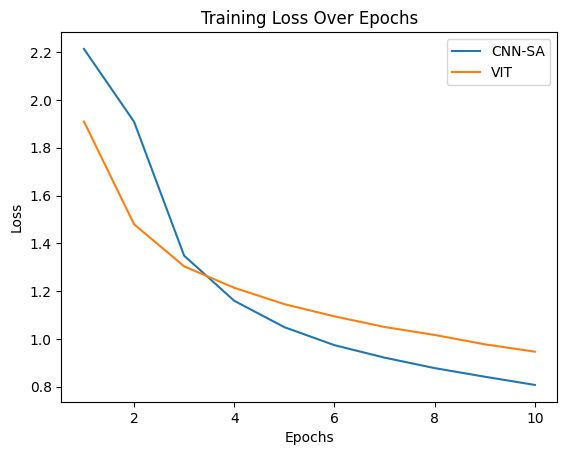

In [15]:
plt.plot(range(1, epochs + 1), Train_loss_data1, label='CNN-SA')
plt.plot(range(1,epochs + 1 ),Train_loss_data2 ,label='VIT')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* CNN-SA is performs slightly better than VIT at later epochs of the training 
* Both has comparable No of parameters
* The following resaons can give the insights 
  - CNN-SA captures the spatial/local patterns 
  - CNN-SA and VIT might need different optimizers
  - VIT might need more embbeding dimensions to be on par with CNN-SA
  - VIT can improve compared to CNN-SA if given suitable EMBED_DIM
  - VIT can perform better on larger datasets where attention is heavily required

#### 2) Lets first observe the Accuracy

In [16]:
print("Accuracy of CNN-SA : ",AC1)
print("Accuracy of VIT : ",AC2)

Accuracy of CNN-SA :  69.28999999999999
Accuracy of VIT :  63.28


* Same as Training loss 
* Both are performing better than Normal FF Networks
* Can be improved with enough training cycles